# Model - Spending "Lifestyles" - LDA and Bag of Words
Coming back to the topic of sequences of credit card transactions and still using the [Sequences of purchases in credit card data reveal
life styles in urban populations](https://www.nature.com/articles/s41467-018-05690-8) paper as a reference, we will explore the patterns in the credit card transactions at a user level.

We aim at developing a "summary" of relevant spending behaviors (lifestyles) in the data. Different from standard approaches, which often take into account monetary value or frequency of purchases on the different categories as features, we will tackle this by finding latent representions of the data in a way similar to that of performing `topic modeling` on text data.

In this notebook, we will utilize `bag-of-words` representations of the data, alongiside a `latent dirchlett allocation (lda)` model to perform `topic modeling` on the user sequences, which, for our purposes, is analogous to a clustering procedure.


In [5]:
# installing dependencies:
!pip install -r ../configs/dependencies/modeling_requirements.txt --upgrade >> ../configs/dependencies/package_installation.txt

In [1]:
# running magic commands:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [1]:
###### Loading the necessary libraries #########

# data wrangling
import pandas as pd
import numpy as np
from tqdm import tqdm

# statistical libraries:
from scipy import stats

# plotting and visualization:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, Image

# machine learning and topic modelling utilities
import umap
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim 

# other libraries:
import warnings
from pprint import pprint

# setting global parameters for visualizations:
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

# 0. Helper Functions

In [2]:
def set_plot_settings():
    """Helper function to set standard plot settings for the jupyter notebook
    Note: these are hard-coded for my specific tastes
    """
    %matplotlib inline
    %pylab inline

    plt.rcParams["figure.figsize"] = [10, 6]
    plt.rcParams["figure.dpi"] = 120
    display(HTML("<style>.container { width:100% !important; }</style>"))
    pd.set_option("display.expand_frame_repr", False)
    sns.set_style("white")


def rotate_xticks(ax, rotation):
    """Helper function to rotate x-axis labels of a matplotlib-based plot

    Args:
        ax (axes.AxesSubplot): matplotlib subplot axis object that handles the figure
        rotation (int): degrees for which to rotate the axis x-ticks

    Returns:
        None

    """
    for item in ax.get_xticklabels():
        item.set_rotation(rotation)


def sequence_tokenizer(sequence):
    """Simple tokenizer function to parse comma-separated sequences o MCCs"""
    return sequence.split(",")


def tune_topic_model(
    dictionary, corpus, sequences, param_name, param_range, coherence_type="c_v"
):
    """Helper function to calculate coherence values accross different model settings

    Args:
        dictionary : Gensim dictionary
        corpus : Gensim corpus
        texts : List of input texts
        limit : Max num of topics

    Returns:
        models : List of LDA topic models
        coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    models = []

    # enabling default parameters (some will be overriden by the param choice)
    param_dict = {
        "corpus": corpus,
        "id2word": dictionary,
        "random_state": 42,
        "chunksize": 100,
        "passes": 10,
        "update_every": 1,
        "per_word_topics": True,
        "alpha": "auto",
        "num_topics": 5,
    }

    # default start is 2
    for param_value in tqdm(param_range):

        input_params = param_dict
        input_params[param_name] = param_value

        model = gensim.models.ldamodel.LdaModel(**input_params)

        models.append(model)

        coherence_model = CoherenceModel(
            model=model,
            texts=sequences,
            dictionary=dictionary,
            coherence=coherence_type,
        )

        coherence_values.append(coherence_model.get_coherence())

    return models, coherence_values

def get_lda_cluster(df, model, corpus):
    topics = []

    for user in corpus:
        temp_df = pd.DataFrame(model.get_document_topics(user))
        temp_df = temp_df.set_index(0)
        main_topic = temp_df.idxmax().values[0]
        topics.append(main_topic)

    df["cluster"] = topics

    return df

In [3]:
# setting the global variables for plotting:
set_plot_settings()

Populating the interactive namespace from numpy and matplotlib


# 1. Loading and Inspecting the Data

In [4]:
# loading the raw dataset:
PROCESSED_DATA_DIR = "../data/processed/"

# reading sequence dataset:
df_sequence = pd.read_parquet(PROCESSED_DATA_DIR + "tb_user_token_history.parquet")

# reading the helper dataset:
df_daily = pd.read_parquet(PROCESSED_DATA_DIR + "tb_user_daily_sequence.parquet")

In [5]:
# checking a sample of the timeline dataset:
df_sequence.sample(5)

,user_id,sequence
806,932,"🍺🎫🏬🚕,💊🏬📺🚕,🏬🍽,🍺🎫⛽🍽🏨🚗🚕,🎫🍺🚕🏬,🛒🎫🌯,💊🍺🚕,🍺🌯🚕,🛒🎫💊💈🚕,🍽🚕..."
588,632,"🛒,📚💊,📚📺,🛒🚗,💊,🍽,💰,🛒📱💰,🛒🏬,💰🏬,🍽📚,🛒💊,💊💰,🛒🍽,💈🏬,🏬💰,💰..."
326,28,"🏬,👕🍽💰,👕,🛒🏬🚗👚🍽,🏬👕,📱,🛒🏬,⛽,🏬🏠🍽,🏗,👕🎥,🛒🏬,👕⛽💊,🏬,👕💰,💰..."
768,1904,"🍽🍺🚗,💊,📱🛒🍺✈,🍽🍺🪑🏨🌯🚗,🍺🏗🌯💰,🍺,🌯🩺,🍺📮🍽🏬,🧹,🍺🌯,🛒🏬🏛,⛽🍺🏬👕..."
1153,1950,"💰🏬🏗🛒,⛽💊,🏬🛒🎥🍺,🏬💊,🛒💊,💰💊🏗,💰🏬⛽🏗💊,💰🏬🏗💊🛒📚🍽,🛒,💊🏬🛒,🌻🏬🛒..."


In [6]:
# sequence dataset:
df_sequence.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   2000 non-null   object
 1   sequence  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


# 2. Tokenizing Sequences of Transactions
We will start the modeling process by preparing the sequences for a bag of words representation. For each user we will generate a list of "words" he or she contains. This is done by splitting on the previously defined comma separator.

In [7]:
# generating the sentences for each user:
sequences = list(map(lambda seq: seq.split(","), df_sequence.sequence.values))

In [8]:
# verifying some of the results:
sequences[0][:10]

['🛒', '⛽🏬💊💰🛒🏠', '🏬💰', '⛽🏬', '🛒💊📱', '🏬💰🛒', '🏬⛽💰🏠', '🛒💰⛽', '🧹💰🏬', '🏬💰⛽']

# 3. Building the Training Corpora

In [9]:
# using gensim's Dictionary to build the corpora representation out of the raw tokenized sequences:
id_to_seq_map = corpora.Dictionary(sequences)

In [10]:
# generating the full corpus (gensim's representation)
corpus = list(map(lambda seq: id_to_seq_map.doc2bow(seq), sequences))

# 2. Building the first Topic Model
To start the model experiments, we will use parameters to those defined on the [reference paper](https://www.nature.com/articles/s41467-018-05690-8), with the number of topics = `6`.

In [13]:
# we will start by defining 6 topics (analogous to the 6 clusters defined by the paper)
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id_to_seq_map,
    num_topics=6,
    random_state=42,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha="auto",
    per_word_topics=True,
)

<IPython.core.display.Javascript object>

In [14]:
# let's print the keywords per topic identified:
pprint(lda_model.print_topics())

[(0,
  '0.083*"🧾" + 0.032*"🛒🧾" + 0.025*"🧾🛒" + 0.017*"🧾🍽" + 0.014*"🧾🏬" + 0.012*"🏬🧾" '
  '+ 0.009*"🧾⛽" + 0.008*"🧾🌯" + 0.008*"🚃" + 0.008*"🧾💰"'),
 (1,
  '0.126*"💰" + 0.047*"🛒💰" + 0.025*"💰🛒" + 0.020*"💰🏬" + 0.019*"🏬💰" + 0.012*"⛽💰" '
  '+ 0.011*"💊💰" + 0.011*"💰💊" + 0.011*"💰🍽" + 0.010*"💰⛽"'),
 (2,
  '0.112*"🛒" + 0.065*"🏬" + 0.034*"💊" + 0.033*"⛽" + 0.023*"🚗" + 0.022*"🛒🏬" + '
  '0.016*"🏬🛒" + 0.015*"🍺" + 0.012*"📚" + 0.012*"🏠"'),
 (3,
  '0.107*"🚕" + 0.035*"🛒🚕" + 0.022*"🚕🛒" + 0.015*"🚕🏬" + 0.012*"🏬🚕" + 0.011*"🚕🍽" '
  '+ 0.011*"⛽🚕" + 0.011*"🍽🚕" + 0.008*"🚕⛽" + 0.007*"💰🚕"'),
 (4,
  '0.000*"🍽🏠🏗📚" + 0.000*"🍽🏠🏬🚗💉" + 0.000*"🍽🏗🏬💈🚗💊🛒" + 0.000*"🍽🏗🏬📱🚗" + '
  '0.000*"🍽🏗💰📺⛽" + 0.000*"🍽🏗💰🚗🏬" + 0.000*"🍽🏗📚🚗⛽" + 0.000*"🍽🏗🚗🏬🎧" + '
  '0.000*"🍽🏗🚗💊⛽" + 0.000*"🍽🏗🚗🛒💉"'),
 (5,
  '0.087*"🍽" + 0.039*"🌯" + 0.039*"🛒🍽" + 0.027*"🛒" + 0.020*"🍽🛒" + 0.018*"🛒🌯" + '
  '0.015*"🏬🍽" + 0.011*"⛽🍽" + 0.011*"🛒⛽" + 0.010*"🍽🏬"')]


<IPython.core.display.Javascript object>

In [15]:
# registering the lda projection for each user
user_lda = lda_model[corpus]

<IPython.core.display.Javascript object>

# 3. Interpreting Preliminar Model Results
In order to assess the quality of our topic model, we will verify some metrics associated with it, namely `perplexity` and `coherence`. Key indicators about the performance and quality of our topic representations in the model are that, the lower the `perplexity`, the best. On the other hand, the higher the `coherence`, the better.

In [16]:
# extracting the perplexity from thee model:
perplexity = lda_model.log_perplexity(corpus)

<IPython.core.display.Javascript object>

In [17]:
# calculating coherence
lda_coherence = CoherenceModel(
    model=lda_model, texts=sequences, dictionary=id_to_seq_map, coherence="c_v"
)

coherence = lda_coherence.get_coherence()

<IPython.core.display.Javascript object>

In [18]:
# verifying the metrics:
print(
    f"""
Preliminar Model metrics:
    perplexity = {perplexity}
    coherence = {coherence}
"""
)


Preliminar Model metrics:
    perplexity = -8.610396483832869
    coherence = 0.6454455620897868



<IPython.core.display.Javascript object>

In [23]:
# let's visualize the model:
pyLDAvis.enable_notebook()
explorer = pyLDAvis.gensim.prepare(lda_model, corpus, id_to_seq_map)
pyLDAvis.display(explorer)

<IPython.core.display.Javascript object>

![LDA Example Plot](../reports/img/LDA_PREM_MODEL_SCREEN.png)

Investigating the results obtained, we can see that our `coherence`, is quite good considering the coherence model we chose (`c_v`). The higher this number is, the better. 

The visualization of the inter-topic distance map also shows us a significant separation of topics in both their locations in the different quadrants of the project, as well as their size and variety upon inspection. 

However, we still see a few problems:

1. Topics `1` and ``2 have significant overlap. This means that it is likely that, when we retrieve the most significant topics for each user, topic `2` will be overuled. This might point out that we have too many topics or "clusters";
2. Topic `1` captures the vast majority of the tokeens observed in the dataset. This topic is likely denoting the most "usual" patterns or behaviors, which is a deficiency of using Bag of Words representations. Some combinations might effectively become "stop words", or purchasing patterns that most if not all users make. This is hard to get, though, as the "stop words" vary by population make-up and culture. In some places is more common that people cook at home, in others, this might not be the case.
3. Topic `6` has no representation whatsover (a junk topic). We need to **remove it**;

In [ ]:
# let's try to tune the parameters of our model as to improve coherence (and hopefully, reduce the effects observed above):
n_topics_range = list(range(2, 9))

model_list, coherence_values = tune_topic_model(
    dictionary=id_to_seq_map,
    corpus=corpus,
    sequences=sequences,
    param_name="num_topics",
    param_range=n_topics_range,
)

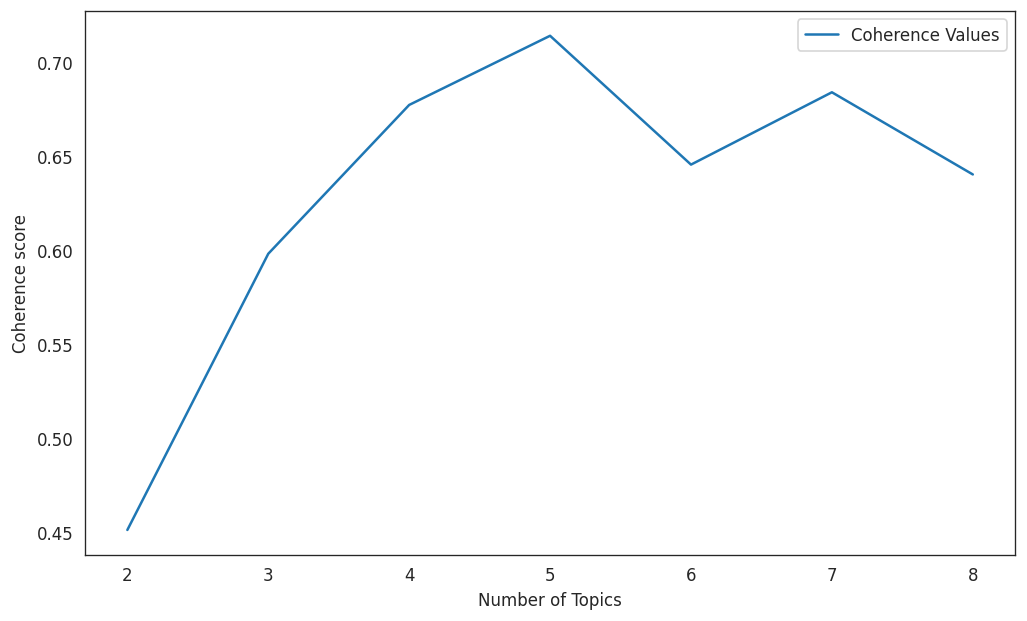

<IPython.core.display.Javascript object>

In [56]:
plt.plot(n_topics_range, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(["Coherence Values"], loc="best")
plt.show()

From the results of our experiment it seems that the best model by number of topic is that of `5`. We will consider this for further improvements.

In [11]:
# defining the tuned model:
lda_model_tuned = model_list[3]

In [12]:
# printing the topics for the model:
pprint(lda_model_tuned.print_topics())

[(0,
  '0.083*"🧾" + 0.032*"🛒🧾" + 0.025*"🧾🛒" + 0.017*"🧾🍽" + 0.014*"🧾🏬" + 0.012*"🏬🧾" '
  '+ 0.009*"🧾⛽" + 0.008*"🧾🌯" + 0.008*"🧾💰" + 0.007*"🍽🧾"'),
 (1,
  '0.118*"💰" + 0.041*"🛒💰" + 0.023*"💰🛒" + 0.019*"💰🏬" + 0.018*"🏬💰" + 0.011*"⛽💰" '
  '+ 0.011*"💰💊" + 0.011*"💊💰" + 0.010*"💰🍽" + 0.009*"💰⛽"'),
 (2,
  '0.105*"🛒" + 0.055*"🏬" + 0.031*"⛽" + 0.029*"💊" + 0.020*"🛒🏬" + 0.019*"🚗" + '
  '0.014*"🏬🛒" + 0.013*"🍽" + 0.012*"🍺" + 0.011*"🛒⛽"'),
 (3,
  '0.101*"🚕" + 0.033*"🛒🚕" + 0.020*"🚕🛒" + 0.015*"🚕🏬" + 0.011*"🏬🚕" + 0.010*"🚕🍽" '
  '+ 0.010*"⛽🚕" + 0.010*"🍽🚕" + 0.008*"🚕⛽" + 0.007*"💰🚕"'),
 (4,
  '0.090*"🍽" + 0.047*"🛒🍽" + 0.039*"🌯" + 0.022*"🛒🌯" + 0.018*"🏬🍽" + 0.014*"🍽🛒" + '
  '0.013*"⛽🍽" + 0.010*"🍽🌯" + 0.010*"💊🍽" + 0.009*"🌯🍽"')]


In [13]:
# registering the lda projection for each user
user_lda = lda_model_tuned[corpus]

In [14]:
# extracting the metrics for the tuned model:
perplexity_tuned = lda_model_tuned.log_perplexity(corpus)

# calculating coherence
lda_coherence = CoherenceModel(
    model=lda_model_tuned, texts=sequences, dictionary=id_to_seq_map, coherence="c_v"
)

coherence_tuned = lda_coherence.get_coherence()

In [15]:
# verifying the metrics:
print(
    f"""
Preliminar Model metrics:
    perplexity = {perplexity_tuned}
    coherence = {coherence_tuned}
"""
)


Preliminar Model metrics:
    perplexity = -8.465310377348153
    coherence = 0.7140612180527642



In [18]:
# let's visualize the tuned model:
pyLDAvis.enable_notebook()
explorer = pyLDAvis.gensim.prepare(lda_model_tuned, corpus, id_to_seq_map)
pyLDAvis.display(explorer)

By looking at the model results, we observe that we obtain not only a better coherence, but better topic descriptions, eliminating the "junk" topic and further separating the topics in inter-topic distance projection map above. We will consider this as a our final model.

# 4. Exporting Model Results

In [16]:
# adding the main topic as a cluster to each user:
df_clusters = get_lda_cluster(df_sequence, lda_model_tuned, corpus)[['user_id', 'cluster']]

In [17]:
# verifying the proportion of users in each cluster:
df_clusters.groupby('cluster')[['user_id']].count() # we see topic 2 is the most representative

,user_id
cluster,
0,188
1,106
2,1386
3,149
4,171


In [19]:
# exporting the results for further studies:
df_clusters.to_parquet("../data/predict/user_cluster_lda_token_sequence.parquet")

In [20]:
# exporting model:
lda_model_tuned.save("../models/lda_user_sequences.model")